In [1]:
import numpy as np
import pandas as pd
import os
import sys
import math
import datetime as dt
from timeit import default_timer as timer
import dateutil.parser as par
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import Vectors
import pyspark.ml.linalg
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import MinMaxScaler
from pyspark import SparkContext, SparkConf
from mpl_toolkits.mplot3d import Axes3D

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
conf = SparkConf().setAppName("yelp").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [4]:
spark = SparkSession \
    .builder \
    .appName("KMeans-yelp-app") \
    .config("spark.some.config.option", "yelp-KMeans") \
    .getOrCreate()
today = dt.datetime.now()

In [5]:
# Getting the data
df_spark = sc.parallelize(spark.read.json("/Users/nandish/Desktop/Semester 1/CPSC 531/Project - Big data analytics/Datasets/Yelp - Kaggle/yelp_academic_dataset_user.json")\
                          .select("review_count", "average_stars", "yelping_since")\
                          .rdd.map(lambda x: (x[0],x[1], (today - par.parse(x[2])).days))\
                          .collect()[10000:15000])

In [6]:
# Preserving the shape of the original distribution
scaler = MinMaxScaler(inputCol="_1",\
         outputCol="scaled_1")
df_test = df_spark.map(lambda x: pyspark.ml.linalg.Vectors.dense(x)).map(lambda x:(x, )).toDF()
model_scaler = scaler.fit(df_test)
vector_df = model_scaler.transform(df_test).select("scaled_1").rdd.map(lambda x:Vectors.dense(x))

In [7]:
# Sum of the Square of Distances to find the Solhoutte Values of different number of clusters to get optimal cluster number
ssq_distance = []
K = range(1,15)

for k in K:
    km = KMeans()
    kme = km.train(vector_df, k= k, maxIterations=20, initializationMode = "random", seed=2018)
    err = vector_df.map(lambda x: (x[0], kme.predict(x[0]))).collect()

    per_clus = [0] * k
    per_clus_num = [0] *k

    # Silhoutte Value comparison
    ag = 0
    agi = 5000
    for er in err:
        avg = [0] * k
        avgi = [0] * k
        for e in err:
            avg[e[1]] += Vectors.squared_distance(er[0], e[0])
            avgi[e[1]] += 1
        a = avg[er[1]] / avgi[er[1]]
        b = math.inf
        for i in range(len(avg)):
            if (i != er[1] and avgi[i]!=0):
                if (avg[i] / avgi[i] < b):
                    b = avg[i] / avgi[i]
        ag += (b - a) / max(b, a)
        per_clus[er[1]] += (b - a) / max(b, a)
        per_clus_num[er[1]] += 1

    sil = (ag / agi)

    ssq_distance.append(sil)

C:\users\nandish\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\users\nandish\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


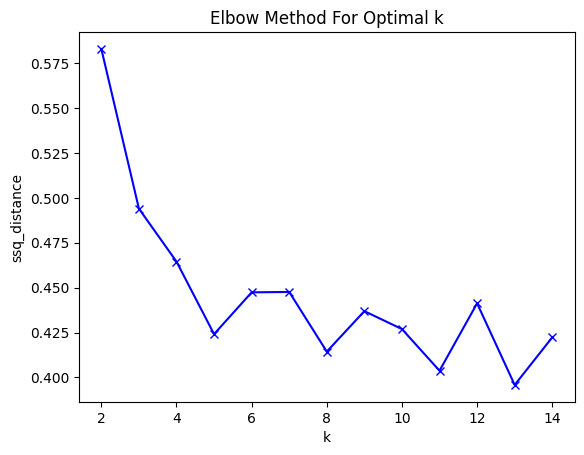

In [8]:
#PLot the elbow graph to get the optimal number of clusters
plt.plot(K, ssq_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('ssq_distance')
plt.title('Elbow Method For Optimal k')
plt.show()

In [9]:
# Initialize K Means
km = KMeans()
start = timer()
kme = km.train(vector_df, k = 5, maxIterations = 20, initializationMode = "random", seed=2018)
end = timer()
print(end - start)
print(kme.computeCost(vector_df))
centroids = kme.clusterCenters
n_clus = 5
err = vector_df.map(lambda x:(x[0], kme.predict(x[0]))).collect()

per_clus = [0]*n_clus
per_clus_num = [0]*n_clus

11.037598200000048
71.56742761557743


In [10]:
# evaluator = ClusteringEvaluator(featuresCol='iris_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

# KMeans_=KMeans() 
# KMeans_Model=KMeans_.fit(vector_df)

In [11]:
#Silhoutte Value comparison
ag = 0
agi = 5000
for er in err:
    avg = [0] * n_clus
    avgi = [0] * n_clus
    for e in err:
        avg[e[1]] += Vectors.squared_distance(er[0], e[0])
        avgi[e[1]] += 1
    a = avg[er[1]] / avgi[er[1]]
    b = math.inf
    for i in range(len(avg)):
        if (i != er[1]):
            if (avg[i] / avgi[i] < b):
                b = avg[i] / avgi[i]
    ag += (b - a)/max(b, a)
    per_clus[er[1]] += (b - a)/max(b, a)
    per_clus_num[er[1]] += 1

sil = (ag/agi)

print(sil)

0.4241016339748286


In [12]:
# Number of points in each cluster
df_with = sc.parallelize(err).map(lambda x:(x[1], 1)).reduceByKey(lambda a, b: a+b).collect()
for ji in df_with:
    print(ji)

for i in range(len(per_clus)):
    print(per_clus[i]/per_clus_num[i])

(0, 904)
(1, 1209)
(2, 1340)
(3, 838)
(4, 709)
0.4718918349441561
0.45630791469965665
0.4275392566164074
0.2806341153797624
0.47132255240975385


# Visualization

In [13]:
# Initialize K Means
km = KMeans()
kme = km.train(vector_df, k = 5, maxIterations = 20, initializationMode = "random", seed=2018)
print(kme.computeCost(vector_df))
print(kme.clusterCenters)
df_with = spark.createDataFrame(vector_df.map(lambda x:(float(x[0][0]), float(x[0][1]), float(x[0][2]), 1))).toPandas()


71.56742761557743
[array([0.02854171, 0.63019815, 0.52344296]), array([0.01924387, 0.79526305, 0.22592093]), array([0.02371407, 0.77149024, 0.40249634]), array([0.01855048, 0.55690789, 0.2827655 ]), array([0.02854305, 0.72035511, 0.71421933])]


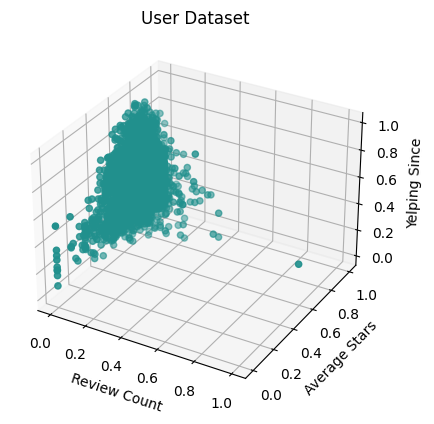

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter(df_with['_1'], df_with['_2'], df_with['_3'], c=df_with['_4'])
ax.set_title('User Dataset')
ax.set_xlabel('Review Count')
ax.set_ylabel('Average Stars')
ax.set_zlabel('Yelping Since')
cbar = plt.colorbar(scatter)
cbar.remove()
plt.show()